# Preprocessing

### Examine the Dataset

In [1]:
import librosa.display
import librosa.util
import matplotlib.pyplot as plt
from IPython.display import Audio
import os
import scipy
import numpy as np

In [2]:
clean_audio_dir = "../data/raw/edinburgh-noisy-speech-db/clean_trainset_28spk_wav/"
audio_file = "p236_002.wav"
clean_audio_f = clean_audio_dir + audio_file
Audio(clean_audio_f)

In [6]:
y_noise, sr = librosa.load(clean_audio_f)
# you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
noise_amp = 0.15*np.random.uniform()*np.amax(y_noise)
y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
Audio(y_noise, rate=sr)

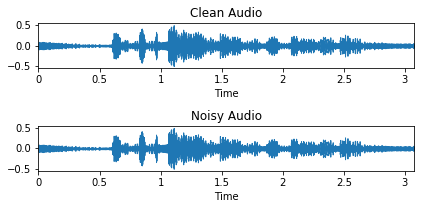

In [7]:
# Plot the waveforms, sr = 22050
y, sr = librosa.load(clean_audio_f)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Clean Audio')

plt.subplot(3, 1, 2)
librosa.display.waveplot(y, sr=sr)
plt.title('Noisy Audio')

plt.tight_layout()

### Short-Time Fourier Transform

First, convert samples into STFT

In [8]:
window_length = 256;
win = scipy.signal.hamming(window_length,"periodic");
hop_length = round(0.25 * window_length);
fft_length = window_length;

In [9]:
# downsampling to 8k
input_fs = sr;
fs = 8e3;

y = librosa.resample(y, target_sr = fs, orig_sr = sr)
y_noise = librosa.resample(y_noise, target_sr = fs, orig_sr = sr)
sr = fs

In [10]:
n = len(y)
y_pad = librosa.util.fix_length(y, n + fft_length // 2)
D = librosa.stft(y_pad.astype(np.float32),
    n_fft = fft_length,
    win_length = window_length,
    window = win,
    hop_length = hop_length)
magnitude, phase = librosa.magphase(D)

In [11]:
D.dtype

dtype('complex64')

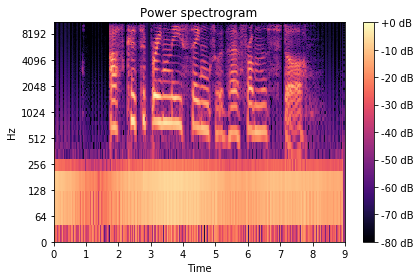

In [12]:
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

At this point, we will use the generate new magnitudes using our NN

In [13]:
D.shape

(129, 387)

Then, invert STFT back to audio format

In [14]:
D_rec = magnitude * phase 

In [15]:
audio_rec = librosa.istft(D_rec,
    length=n,
    win_length = window_length,
    window = win,
    hop_length = hop_length)

In [16]:
Audio(audio_rec, rate = sr)

### Building Targets and Predictors

In [17]:
num_features  = fft_length/2 + 1;
num_segments  = 8;

predictors = []
targets = []

y_pad = librosa.util.fix_length(y, n + fft_length // 2)
D_clean = librosa.stft(y_pad.astype(np.float32),
    n_fft = fft_length,
    win_length = window_length,
    window = win,
    hop_length = hop_length)
mag_clean = np.abs(D_clean)

y_pad_noise = librosa.util.fix_length(y_noise, n + fft_length // 2)
D_noise = librosa.stft(y_pad_noise.astype(np.float32),
    n_fft = fft_length,
    win_length = window_length,
    window = win,
    hop_length = hop_length)
mag_noise = np.abs(D_noise)


# Create array of targets and predictors
for segment_index in range(mag_noise.shape[1] - num_segments):
    predictors.append(magnitude[:, segment_index:segment_index + num_segments - 1])
    targets.append(magnitude[:,segment_index + num_segments - 1])

In [18]:
print(len(predictors))
print(len(targets))

379
379


In [19]:
predictors = np.array(predictors)
predictors.shape

(379, 129, 7)

### Full Script

TODO: Full Script which will take process all the audio files in raw format and store them in processed format, using the above constraints

Script should store data in a format that can be easily saved are retrieved for later use

In [21]:
import os
import librosa
import scipy
import numpy as np
import progressbar
import pickle

def get_stft(y, sr):
    # define vars
    window_length = 256;
    win = scipy.signal.hamming(window_length,"periodic");
    overlap = round(0.75 * window_length);
    fft_length = window_length;
    # downsampling
    target_sr = 8e3;
    y = librosa.resample(y, target_sr = target_sr, orig_sr = sr)
    sr = target_sr
    # padding, because input must be multiple of fft window
    n = len(y)
    y_pad = librosa.util.fix_length(y, n + fft_length // 2)
    # get STFT
    D = librosa.stft(y_pad.astype(np.float32),
        n_fft = fft_length,
        win_length = window_length,
        window = win,
        hop_length = overlap)
    return D

def process_audio(process_all = False):
    raw_dir = "../data/raw/edinburgh-noisy-speech-db/"
    processed_dir = "../data/processed/edinburgh-noisy-speech-db/"
    clean_audio_dir = "clean_trainset_28spk_wav/"
    log_trainset = "log_trainset_28spk.txt"
    audio_files = []
    
    num_features  = 129;
    num_segments  = 8;

    dataset = {
        "predictors": [],
        "targets": []
    }
    
    # list files
    f = open(raw_dir + log_trainset, "r")
    for x in f:
        audio_files.append(x.split()[0] + ".wav")
    f.close()
    
    if process_all == False:
        audio_files = audio_files[0:128]
        
    print("Processing " + str(len(audio_files)) + " files")
    
    with progressbar.ProgressBar(max_value=len(audio_files)) as bar:
        for i, f in enumerate(audio_files):
            for a in ["clean", "noisy"]:
                y, sr = librosa.load(raw_dir + clean_audio_dir + f)
                
                if a == "noisy":
                    noise_amp = 0.15*np.random.uniform()*np.amax(y)
                    y = y.astype('float64') + noise_amp * np.random.normal(size=y.shape[0])
                
                D = get_stft(y, sr)
                magnitude = np.abs(D)
                
                for segment_index in range(magnitude.shape[1] - num_segments):
                    if a == "noisy":
                        dataset["predictors"].append(magnitude[:, segment_index:segment_index + num_segments])
                    else:
                        dataset["targets"].append(magnitude[:,segment_index + num_segments])
            bar.update(i)
    
    dataset["predictors"] = np.array(dataset["predictors"])
    dataset["targets"] = np.array(dataset["targets"])
    with open(processed_dir + "train.pkl", 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("processing finished")        
    
    return dataset
            
processed_dataset = process_audio()

Processing 128 files


100% (128 of 128) |######################| Elapsed Time: 0:00:39 Time:  0:00:39


processing finished


In [22]:
for p in processed_dataset["predictors"]:
    if (p.shape[0] != 129):
        print("Error")
    if (p.shape[1] != 8):
        print("Error")
print("Finish Validation Check")

Finish Validation Check


In [23]:
for p in processed_dataset["targets"]:
    try:
        p.shape[1]
        print("Error")
    except:
        pass
    
print("Finish Validation Check")

Finish Validation Check
